# Midrex ND Plant 

In this example we will calculate the heat requirement considering midrex reformer and shaft furnace in a Midrex Natural Gas Plant by utilizing stream objects.

Stream calculation in ChemApp for Python allows setting initial conditions in addition to general boundary conditions. This enables quick calculation of heat balances and modeling scenarios.

![Midrex ND Plant flowchart ](MidrexND.png)


Source: MIDREX NG Brochure (4.12.2018)

## Reformer and Shaft Furnace in Midrex Reactor

The MIDREX Reformer plays a crucial role in the production of direct reduced iron (DRI) in the MIDREX Shaft Furnace. In the Shaft Furnace, iron oxide reacts with a hot gas containing H2 and CO, resulting in the reduction of iron oxide into metallic iron (Fe), with CO2 and H2O as byproducts. The MIDREX Reformer heats and catalytically reforms natural gas, recycling CO2 and H2O from the reduction process to generate a rich reducing gas for DRI production. The Reformer also recycles byproducts and unreacted gases to minimize energy consumption and provide the necessary energy for reduction reactions in the Shaft Furnace.

-> Assumptions have been made to streamline the model, taking into account only a subset of the components of the Midrex Furnace due to the complex nature of the process.

-> In this model, the process gas extracted from the top gas is not recycled into the reformer. Instead, a fixed gas composition is introduced into the reformer. However, the energy contribution from the shaft furnace, referred to as "Top Gas Fuel," has been incorporated into the energy balance equations.

## Initialization and general Setup
Import the Pandas and ChemApp for Python.

In [30]:
import pandas as pd

from chemapp.friendly import (
    ThermochemicalSystem as cats,
    StreamCalculation as casc,
    Units as cau,
    TemperatureUnit,
    AmountUnit,
    EnergyUnit,
    PressureUnit,
)

from chemapp.core import StreamState

## Load data file 
Determine the data file path. Open, read and close the thermochemical data-file midrex-database.cst (system Fe-O-H-C-N).

In [31]:
# Load database
cats.load("midrex_database.cst")

## Info about the CST file thermodynamic system

In [32]:
print(cats.get_str_phs_pcs())

PHASES AND CONSTITUENTS
INDEX PHASE NAME                STATUS     INDEX CONSTITUENT NAME          STATUS
    0 gas_ideal                 ENTERED              0 H                         ENTERED
                                                     1 H2                        ENTERED
                                                     2 C                         ENTERED
                                                     3 C2                        ENTERED
                                                     4 C3                        ENTERED
                                                     5 C4                        ENTERED
                                                     6 C5                        ENTERED
                                                     7 CH                        ENTERED
                                                     8 CH2                       ENTERED
                                                     9 CH3                       ENTERED
    

## Units setup

In [33]:
# Set units
cau.set_A_unit(AmountUnit.kg)
cau.set_T_unit(TemperatureUnit.C)
cau.set_P_unit(PressureUnit.bar)
cau.set_E_unit(EnergyUnit.kWh)

## Set Input Stream 
Routine to define ChemApp for Python stream and incoming amounts. 

In [34]:
def set_input_stream(input_stream_dict: dict, reset_IA=False):
    # Manage incoming amounts
    if reset_IA == True:
        casc.remove_eq_conditions_IA()

    # Create stream object
    casc.create_st(
        name=input_stream_dict["name"],
        T=input_stream_dict["T"],
        P=input_stream_dict["P"],
    )  # C bar

    # Set incoming amount of the stream object
    for phpc in input_stream_dict["percentage"]:
        ph, pc = phpc
        casc.set_IA_pc(
            name=input_stream_dict["name"],
            ph=ph,
            pc=pc,
            value=input_stream_dict["amount"]
            * (input_stream_dict["percentage"][phpc] / 100),
        )  # kg
    return

## Create equilibrium reaction calculator for the reformer 

In a simplified reformer`Stream Reformer` is heated up to an elevated `temperature`. An initial composition of a gas mixture `reformer_initial_input` is provided to reformer. As output `reducing_gas_stream` is obtained to be fed into the `Shaft Furnace`.

In previous code block, "Stream Reformer `reformer_initial_input` temperature is set to 580°C. Below, we will provide a reaction temperature that will also be equal to the output `reducing_gas_stream` temperature.

![Reformer flowchart ](reformer_chart.png)


In [46]:
from numpy import float64


def reformer(input_stream: dict, reformer_T: float, reformer_P: float, print=False):

    # Remove equilibrium conditions
    casc.remove_eq_conditions_all()

    # Set input stream
    set_input_stream(input_stream)

    # Set reaction temperature
    casc.set_eq_P(reformer_P)
    casc.set_eq_T(reformer_T)

    # Calculate equilibrium
    casc.calculate_eq(print_results=print)

    results = casc.get_result_object()

    # get amount of gases
    amount_pcs_in_gas = casc.get_eq_A_pcs_in_ph(0)
    initial_amount_pcs_in_gas = casc.get_eq_IA_pcs_in_ph(0)

    amount_total = casc.get_eq_A_ph(0)
    initial_amount_total = sum(casc.get_eq_IA_pcs_in_ph(0))

    # Get name of gasses for indexing
    name_pcs_in_gas = cats.get_name_pcs_in_ph(0)

    # get wt.% of gases
    wt_pcs_in_gas = [
        gas_constituent / amount_total * 100 for gas_constituent in amount_pcs_in_gas
    ]

    initial_wt_pcs_in_gas = [
        gas_constituent / initial_amount_total * 100
        for gas_constituent in initial_amount_pcs_in_gas
    ]

    # reformer output is the reducing gas stream

    reducing_gas_stream = results.create_stream(
        name="Stream Reducing Gas", include_zeros=False
    )

    # Create dataframe to have an idea about the process

    data = {
        "Gas Input kg": initial_amount_pcs_in_gas,
        "Gas Output kg": amount_pcs_in_gas,
        "Gas Input wt.%": initial_wt_pcs_in_gas,
        "Gas Output wt.%": wt_pcs_in_gas,
    }

    df = pd.DataFrame(data, index=name_pcs_in_gas, dtype=float64)

    # Filter dataframe
    threshold = 1e-4

    df_filtered = df[
        (df["Gas Input kg"] > threshold) | (df["Gas Output kg"] > threshold)
    ]

    enthalpy_change = results.dH

    return reducing_gas_stream, df_filtered, enthalpy_change

## Create equilibrium reaction calculator for the shaft furnace

In a simplified scenerio Shaft furnace is operated at a certain temperature. `reducing_gas_stream` that obtained from Reformer is provided to the Shaft Furnace as well as the hematite ore is fed to the furnace at ambient conditions (25°C,1 bar) by `iron_oxide_stream`. Moreover, to reduce the CO2 emissions, `ammonia_stream` and `hydrogen_stream` is fed to the furnace in a desired ratio. As output `stream_top_gas` and `stream_DRI` is obtained.1/3 of the  gas stream will be used for energy conversation, whereas the 2/3 will be utilized in `Reformer`. The latter solid srteam contains the direct reduced iron, with a certain metallization degree.   

![Shaft furnace flowchart ](shaft_furnace_chart.png)


In [45]:
def shaft_furnace(
    ammonia_stream: dict,
    hydrogen_stream: dict,
    iron_oxide_stream: dict,
    reducing_gas_stream,
    Furnace_T,
    Furnace_P,
    print=False,
):

    # Remove equilibrium conditions
    casc.remove_eq_conditions_all()

    # Set streams
    set_input_stream(ammonia_stream)
    set_input_stream(hydrogen_stream)
    set_input_stream(iron_oxide_stream)

    casc.set_st(reducing_gas_stream)

    # Set furnace T and P
    casc.set_eq_T(Furnace_T)
    casc.set_eq_P(Furnace_P)

    # Calculate and print results if requested

    casc.calculate_eq(print_results=print)

    results = casc.get_result_object()

    # Define output streams

    stream_top_gas = results.create_gas_stream("Stream Top-gas", include_zeros=False)
    stream_DRI = results.create_solid_stream("Stream DRI", include_zeros=False)
    enthalpy_change = results.dH

    # Calculate metallization degree
    # Assuming FCC is the forming phase for Fe

    total_amount_of_DRI_stream = stream_DRI.A
    amount_of_iron = results.phs["FCC_A1#1"].A

    metallization_degree = amount_of_iron / total_amount_of_DRI_stream

    return stream_top_gas, stream_DRI, enthalpy_change, metallization_degree

## Energy calculator 
Calculate the energy required to supply considering the recovered heat from off-gas, and consumed energy based on reaction dH of reformer and shaft furnace.

In [37]:
def energy_balance(
    top_gas_stream: StreamState, shaft_furnace_dH: float, reformer_dH: float
) -> tuple[float, float]:
    """Calculate the energy balance of the process.

    Args:
        top_gas_stream: _description_
        shaft_furnace_dH (float): _description_
        reformer_dH (float): _description_

    Returns:
        float, float : _description_
    """
    # One third of the energy is recovered from topgas
    # Assuming 100% energy conversion for top_gas_fuel_enthalpy
    casc.set_st(top_gas_stream)

    # Cool down top gas to ambient temperature
    casc.set_eq_T(580)
    casc.calculate_eq(print_results=False)
    resuts = casc.get_result_object()
    # Get recovered enthalpy while cooling. 1/3 of the top gas will be reused as "fuel" for reformer.
    top_gas_fuel_enthalpy = resuts.dH / 3
    shaft_furnace_enthalpy_change = shaft_furnace_dH
    reformer_enthalpy_change = reformer_dH
    total = (
        reformer_enthalpy_change + shaft_furnace_enthalpy_change + top_gas_fuel_enthalpy
    )
    return total, top_gas_fuel_enthalpy

## Set the Midrex process 
Here we can provide input arguments and deploy functions to simulate the simplified midrex reactor. 

In [38]:
# Reformer input
# Define reformer input stream properties
initial_reformer_stream = {
    "name": "Reducing gas stream",
    "T": 580,
    "P": 1,
    "amount": 470,
    "percentage": {
        (0, "H2"): 3.92,
        (0, "CO"): 29.6,
        (0, "CO2"): 36.72,
        (0, "H2O"): 13.02,
        (0, "CH4"): 15.17,
        (0, "N2"): 1.56,
    },
}  # C bar kg wt.%

# Run reformer()
reducing_gas_stream, df_reformer, reformer_enthalpy_change = reformer(
    initial_reformer_stream, reformer_T=950, reformer_P=20, print=False
)  # C bar

# Shaft furnace input
# Define Ammonia input stream properties. Ammonia will be provided to shaft furnace additional to the reformer.
ammonia_stream = {
    "name": "Ammonia Stream",
    "T": 580,
    "P": 1,
    "amount": 268,
    "percentage": {(0, "NH3"): 100},
}  # C bar kg wt.%
hydrogen_stream = {
    "name": "Hydrogen Stream",
    "T": 580,
    "P": 1,
    "amount": 0,
    "percentage": {(0, "H2"): 100},
}  # C bar kg wt.%
# Define Iron Oxide stream properties
iron_oxide_stream = {
    "name": "Iron Oxide Stream",
    "T": 25,
    "P": 1,
    "amount": 1000,
    "percentage": {("Fe2O3_hematite(s)", "Fe2O3_hematite(s)"): 100},
}  # kg

# Run shaft_furnace()
stream_top_gas, stream_DRI, shaft_furnace_enthalpy_change, metallization_degree = (
    shaft_furnace(
        ammonia_stream,
        hydrogen_stream,
        iron_oxide_stream,
        reducing_gas_stream,
        1000,
        1,
        print=True,
    )
)  # C bar

# Run energy_balance()
energy_requirement, recovered_energy_top_gas = energy_balance(
    stream_top_gas, shaft_furnace_enthalpy_change, reformer_enthalpy_change
)

 
 T = 1000 C
 P = 1 bar
 V = 7.0377E+06 dm3

 STREAM CONSTITUENTS              AMOUNT/kg    TEMPERATURE/C   PRESSURE/bar  STREAM
 NH3/gas_ideal/                   2.6800E+02       580.00       1.0000E+00      2
 H2/gas_ideal/                    0.0000E+00       580.00       1.0000E+00      3
 Fe2O3_hematite(s)                1.0000E+03        25.00       1.0000E+00      4
 H/gas_ideal/                     1.5267E-06       950.00       2.0000E+01      5
 H2/gas_ideal/                    3.1581E+01       950.00       2.0000E+01      5
 C/gas_ideal/                     5.1547E-22       950.00       2.0000E+01      5
 C2/gas_ideal/                    4.4351E-25       950.00       2.0000E+01      5
 C3/gas_ideal/                    4.3847E-23       950.00       2.0000E+01      5
 C4/gas_ideal/                    5.3000E-30       950.00       2.0000E+01      5
 C5/gas_ideal/                    6.0439E-30       950.00       2.0000E+01      5
 CH/gas_ideal/                    1.4619E-18      

## Results 
Here we can demonstrate the results of the Midrex process. An overview of the stream management and process flowchart for current process model is described below. 
 
![Midrex flowchart ](midrex_chart.png)

### 1. Reformer stream

In [39]:
print(f"Reformer stream\n {df_reformer}\n")
# The reducing gas ratio (H2:CO) is typically around 1.55(in volume) or 0.11 (in mass)
reducing_gas_ratio = (
    df_reformer.loc["H2", "Gas Output kg"] / df_reformer.loc["CO", "Gas Output kg"]
)
print(f"Reducing gas ratio (in mass): {round(reducing_gas_ratio,2)}")



Reformer stream
        Gas Input kg  Gas Output kg  Gas Input wt.%  Gas Output wt.%
H2           18.424      31.580950        3.920392         6.720023
CH4          71.299      22.701645       15.171517         4.830620
C2H4          0.000       0.002917        0.000000         0.000621
C2H6          0.000       0.003990        0.000000         0.000849
N2            7.332       7.282489        1.560156         1.549621
NH3           0.000       0.057858        0.000000         0.012312
HCN           0.000       0.003661        0.000000         0.000779
H2O          61.194      52.655317       13.021302        11.204379
CO          139.120     295.507847       29.602960        62.880298
CO2         172.584      60.152132       36.723672        12.799606
H2CO          0.000       0.003197        0.000000         0.000680
CH2CO         0.000       0.000174        0.000000         0.000037
HCOOH         0.000       0.000523        0.000000         0.000111

Reducing gas ratio (in mass): 

We can compare the results with the actual plant data:
|  Gas  | Input (wt.%)         | Output (wt.%)        |
|-------|----------------------|----------------------|
| H2    | 3.92                 | 8.33                 |
| CO    | 29.60                | 73.63                |
| CO2   | 36.72                | 6.61                 |
| H2O   | 13.03                | 8.12                 |
| CH4   | 15.17                | 1.20                 |
| N2    | 1.56                 | 2.10                 |

Reducing gas ratio (in mass): 0.11, (in volume): 1.55 

Source: MIDREX NG Brochure (4.12.2018)

### 2. Shaft furnace: top gas 

In [40]:
print(f"Stream top gas\n {stream_top_gas}\n")

Stream top gas
Stream State
---------------------------------------------------------------
Class:       chemapp.core.StreamState

Name:        Stream Top-gas
T:           1.0000E+03 C
P:           1.0000E+00 bar
Cp:          7.5361E-01 kWh/C
H:           -1.2722E+03 kWh
S:           4.2006E+00 kWh/C
G:           -6.6202E+03 kWh
V:           7.0377E+06 dm3
---------------------------------------------------------------
Phase                     Constituent                         A
                                                             kg
---------------------------------------------------------------
gas_ideal                 H                          3.0836E-05
gas_ideal                 H2                         5.5458E+01
gas_ideal                 C                          1.3060E-21
gas_ideal                 C2                         6.7889E-27
gas_ideal                 C3                         2.2803E-27
gas_ideal                 C4                         1.9518E-36
g

### 3. Shaft furnace: DRI and metallization degree

In [41]:
print(f"Stream DRI\n {stream_DRI}\n")

Stream DRI
Stream State
---------------------------------------------------------------
Class:       chemapp.core.StreamState

Name:        Stream DRI
T:           1.0000E+03 C
P:           1.0000E+00 bar
Cp:          1.2477E-01 kWh/C
H:           1.0279E+02 kWh
S:           2.8029E-01 kWh/C
G:           -2.5406E+02 kWh
V:           0.0000E+00 dm3
---------------------------------------------------------------
Phase                     Constituent                         A
                                                             kg
---------------------------------------------------------------
FCC_A1#1                  Fe                         6.7607E+02
FCC_A1#1                  O                          3.8262E-07
FCC_A1#1                  FeC                        2.6818E-01
FCC_A1#1                  OC                         2.1868E-10
FCC_A1#1                  FeN                        3.2175E-01
FCC_A1#1                  ON                         2.7303E-10
FCC_A1#1  

Metallization degree: 0.9585220117516143, max 1


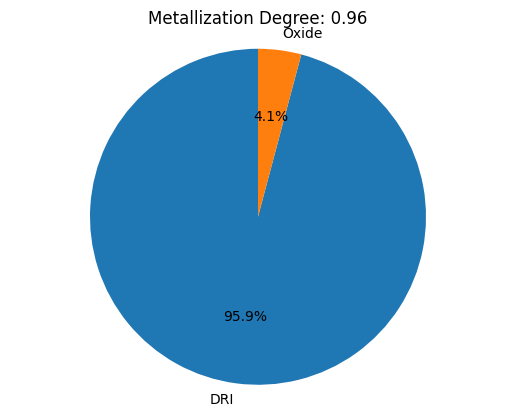

In [44]:
import matplotlib.pyplot as plt


def draw_pie_chart(metallization_degree):

    labels = ["DRI", "Oxide"]

    sizes = [metallization_degree * 100, abs((1 - metallization_degree)) * 100]

    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)

    plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title(f"Metallization Degree: {metallization_degree:.2f}")

    plt.show()


print(f"Metallization degree: {metallization_degree}, max 1")


draw_pie_chart(metallization_degree)

### 4. Energy requirement

Energy requirement:                  931.49 kWh
Recovered energy from top gas       -183.06 kWh
Shaft furnace energy requirement     783.85 kWh
Reformer energy requirement          330.71 kWh



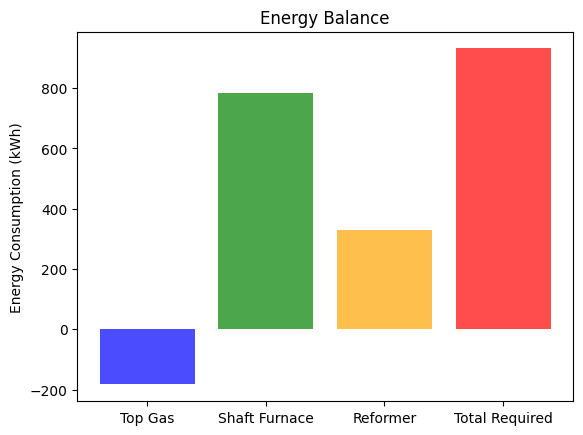

In [43]:
print(
    f"{'Energy requirement: ':<35}{round(energy_requirement,2):8.2f} {cau.get_E_unit().name}"
)

print(
    f"{'Recovered energy from top gas ':<35}{ recovered_energy_top_gas :8.2f} {cau.get_E_unit().name}\n"
    f"{'Shaft furnace energy requirement ':<35}{shaft_furnace_enthalpy_change:8.2f} {cau.get_E_unit().name}\n"
    f"{'Reformer energy requirement ':<35}{reformer_enthalpy_change:8.2f} {cau.get_E_unit().name}\n"
)

plt.bar(
    x=["Top Gas", "Shaft Furnace", "Reformer", "Total Required"],
    height=[
        recovered_energy_top_gas,
        shaft_furnace_enthalpy_change,
        reformer_enthalpy_change,
        energy_requirement,
    ],
    color=["blue", "green", "orange", "red"],
    alpha=0.7,
)

plt.ylabel(f"Energy Consumption ({cau.get_E_unit().name})")
plt.title("Energy Balance")
plt.show()